In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=2600
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)

In [4]:
gpu_id = 'cuda:1'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [16]:
# rnn
class RNN(torch.nn.Module):

    def __init__(self, input_dim_speech, hidden_layer_size) -> None:
        super().__init__()

        self.speech_rnn = torch.nn.LSTM(input_dim_speech, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x_speech, text_lens):
        batch_size = x_speech.shape[0]

        interm_states_speech, _ = self.speech_rnn(x_speech)
        final_state_speech = interm_states_speech[torch.arange(batch_size), text_lens - 1, :]

        h = self.dropout(final_state_speech)
        return self.linear(h)

step error


/tmp/ipykernel_3510474/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3510474/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3510474/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.6935873031616211
dev error:  0.6929223537445068
2 0.6931340098381042
dev error:  0.6931998133659363
3 0.6935620903968811
dev error:  0.6932913661003113
4 0.6928681135177612
dev error:  0.6929193735122681
5 0.692953884601593
dev error:  0.6929051876068115
6 0.6926993131637573
dev error:  0.6929990649223328
7 0.692969799041748
dev error:  0.6931795477867126
8 0.6931259632110596
dev error:  0.6930409669876099
9 0.6926270723342896
dev error:  0.6928951740264893
10 0.6926555633544922
dev error:  0.6928821802139282
11 0.6925095915794373
dev error:  0.6928838491439819
12 0.6922594308853149
dev error:  0.692875862121582
13 0.6921913027763367
dev error:  0.6928614377975464
14 0.6920953392982483
dev error:  0.6928625702857971
15 0.6916483640670776
dev error:  0.6926229000091553
16 0.692356288433075
dev error:  0.6924784779548645
17 0.6927343606948853
dev error:  0.6929779052734375
18 0.6914936304092407
dev error:  0.6921805739402771
19 0.6919912099838257
dev error:  0.6920677423477173
20 0.6

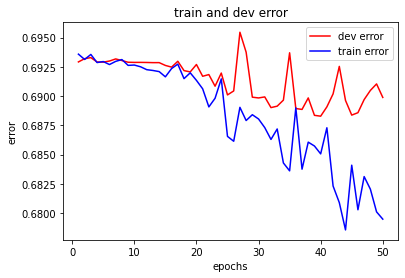

best model after 40 epochs with dev set error 0.6882827877998352


In [17]:
# input features
###
idxs_speech = torch.arange(300, 381) # speech, 81

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim_speech=81, hidden_layer_size=256)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs = 500
patience = 10

print('step', 'error')
dev_errors = []
best_dev_error = np.inf
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = model(x_p[:, :, idxs_speech], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        model.eval()
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0):
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            dev_output = model(x_p[:, :, idxs_speech], x_p_len)
            dev_error = torch.nn.functional.binary_cross_entropy_with_logits(dev_output, y)
        dev_errors.append(float(dev_error))
        print('dev error: ', float(dev_error))

    if dev_error < best_dev_error:
        num_bad_epochs = 0
        best_dev_error = dev_error
        best_epoch = epoch
        torch.save(model, 'punchline_net_speech.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_errors, 'r', label='dev error')
plt.plot(range(1, num_epochs+1), errors, 'b', label='train error')
plt.title('train and dev error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

print('best model after {} epochs with dev set error {}'.format(best_epoch, best_dev_error))
model = torch.load('punchline_net_speech.pth')

In [18]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        output = model(x_p[:, :, idxs_speech], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        scaled_outputs = torch.sigmoid(output)
        predictions = (scaled_outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = scaled_outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test error: ', float(error))
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3510474/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3510474/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3510474/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test error:  0.680260956287384
test accuracy: 55.92%


In [19]:
print(len(hid_humor_t))
print(len(hid_nonhumor_t))
print(len(hid_humor_f))
print(len(hid_nonhumor_f))

language_sdk=load_pickle("language_sdk.pkl")

sorted_humor_t = {k: v for k, v in sorted(hid_humor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_t = {k: v for k, v in sorted(hid_nonhumor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_humor_f = {k: v for k, v in sorted(hid_humor_f.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_f = {k: v for k, v in sorted(hid_nonhumor_f.items(), key=lambda item: item[1], reverse=True)}

for hid, output in list(sorted_humor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_humor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])

252
296
194
238
the good news is i married her the next year
so that's the blueprint of the house
i'm not going to talk about that tonight
but let's say for a moment that you were
but i still have six and a half minutes

there's nothing you can do
you can experience their sense of place
each point here represents all the complex microbes in an entire microbial community
and imagine if through new scientific advances we were just beginning to understand its importance to how we think of ourselves
i have to get out of here actually

each year it sends up a new generation of shoots
with this job all i needed were my hands and my massage table by my side and i could go anywhere
that's what's going on
it's more mundane
they wouldn't have me

all the others have been all those three
a voodoo experiment
i want the happy ending implied by the title to my article which is incidentally the only part of the article that i didn't actually write
i'm a monkey blowing kisses at a butterfly
and well w